# Exploring the Bayesian approach to A/B Testing

A/B testing with controlled randomized trials is considered by many to be the gold standard in learning about differences between groups in experiments.

In this notebook we explore the Bayesian approach to A/B testing to go one level deeper than the usual frequentist approach. We go on to use Thompson sampling to navigate the Explore/Exploit tradeoff that make it difficult to decide which action to take next in the face of uncertainty.

In [1]:
from __future__ import print_function, division
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

Let's setup the experiment to have three different ad creatives each with an assumed probability of conversion.

In [2]:
Num_Trials = 20500
Ad_Conversion_Probabilities = [0.2, 0.5, 0.75]

In [3]:
class Ad_Creative(object):
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1

    def impression(self):
        return np.random.random() < self.p

    def conversion(self):
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += 1 - x

In [4]:
def plot(ad_creatives, trial):
    x = np.linspace(0, 1, 200)
    for a in ad_creatives:
        y = beta.pdf(x, a.a, a.b)
        plt.plot(x, y, label="real p: %.4f" % a.p)
    plt.title("Ad Creative Conversion distributions after %s trials" % trial)
    plt.legend()
    plt.show()

In [5]:
def experiment():
    creatives = [Ad_Creative(p) for p in Ad_Conversion_Probabilities]
    sample_points = [5,10,20,50,100,200,500,1000,1500,20000]
    
    for i in range(Num_Trials):

        # take a sample from each ad creative
        besta = None
        maxsample = -1
        allsamples = [] # let's collect these just to print for debugging
        for c in creatives:
            sample = c.conversion()
            allsamples.append("%.4f" % sample)
            if sample > maxsample:
                maxsample = sample
                bestc = c
        if i in sample_points:
            print("current samples: %s" % allsamples)
            plot(creatives, i)

        # pull the arm for the bandit with the largest sample
        x = bestc.impression()

        # update the distribution for the bandit whose arm we just pulled
        bestc.update(x)

current samples: ['0.1835', '0.1204', '0.9437']


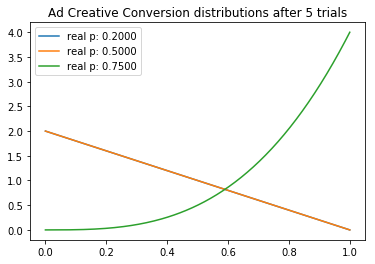

current samples: ['0.4655', '0.0825', '0.9558']


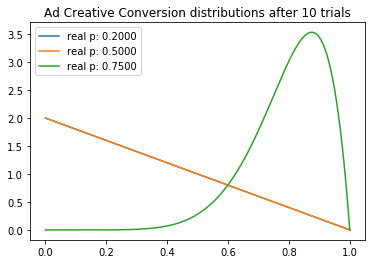

current samples: ['0.3413', '0.5269', '0.7619']


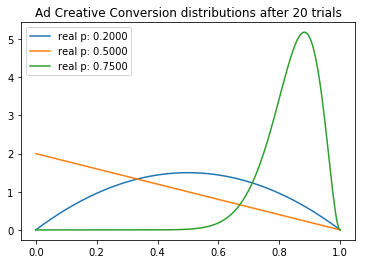

current samples: ['0.2756', '0.1449', '0.7208']


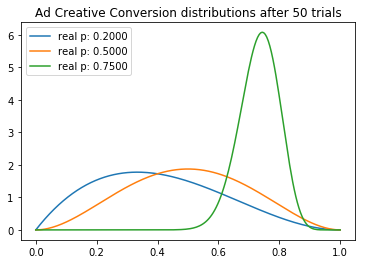

current samples: ['0.0758', '0.1352', '0.7976']


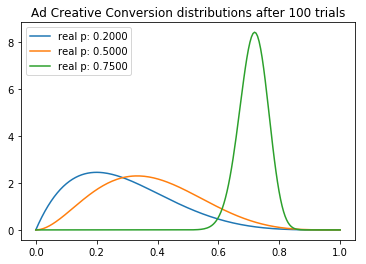

current samples: ['0.2014', '0.1682', '0.7287']


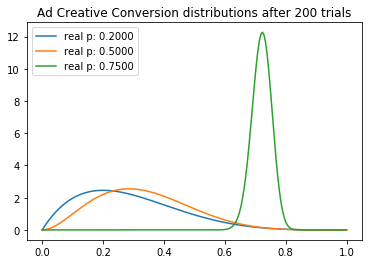

current samples: ['0.2622', '0.4307', '0.7396']


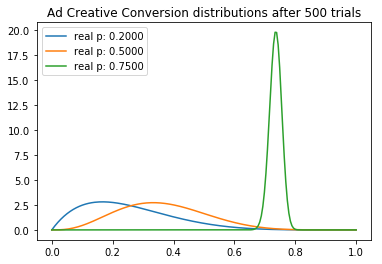

current samples: ['0.1722', '0.5796', '0.7270']


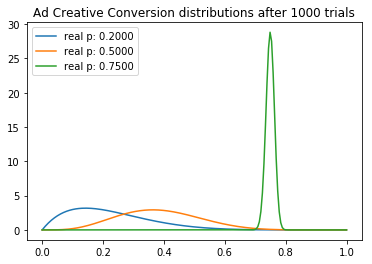

current samples: ['0.2234', '0.3460', '0.7412']


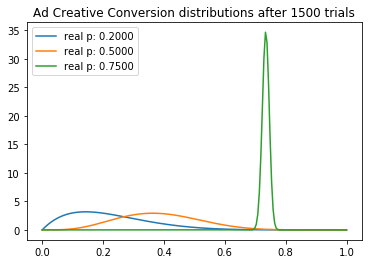

current samples: ['0.1812', '0.3576', '0.7460']


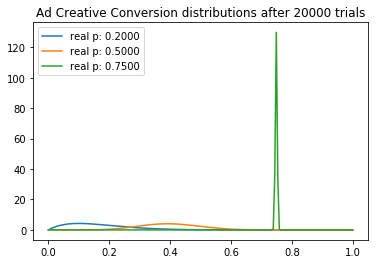

In [6]:
if __name__ == "__main__":
    experiment()

One can see that as more trials are done, we move closer to understanding the true ad creative conversion probability and its distribution. However we don't necessarily want to have to take 20000 trials to get this info. To navigate this we can use Thompson sampling to maintain a bias towards using creatives that we know are successful vs exploring new ones.

In [7]:
#THOMPSON sampling

def run_experiment(p1, p2, p3, N):
    creatives = [Ad_Creative(p1), Ad_Creative(p2), Ad_Creative(p3)]

    data = np.empty(N)
  
    for i in range(N):
    # thompson sampling
        j = np.argmax([c.conversion() for c in creatives])
        x = creatives[j].impression()
        creatives[j].update(x)

    # for the plot
        data[i] = x
    cumulative_average_ctr = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
    plt.plot(cumulative_average_ctr)
    plt.plot(np.ones(N)*p1)
    plt.plot(np.ones(N)*p2)
    plt.plot(np.ones(N)*p3)
    plt.ylim((0,1))
    plt.xscale('log')
    plt.show()

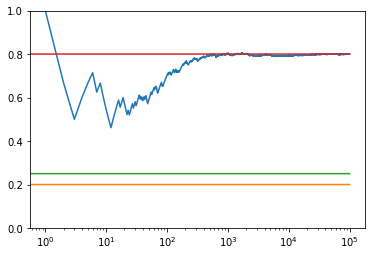

In [8]:
run_experiment(0.2, 0.25, 0.8, 100000)

By using this approach we were able to quite quickly discover and act on the best conversion probability since the difference in success rates are quite high. This approach will also work for ad creatives that are more similar in conversion rates, but may take longer to discover which one is best.

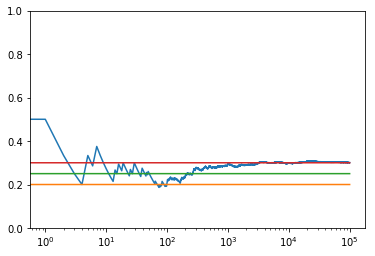

In [9]:
run_experiment(0.2, 0.25, 0.3, 100000)